In [13]:
%pylab inline
#http://www.rricard.me/machine/learning/generative/adversarial/networks/keras/tensorflow/2017/04/05/gans-part2.html

import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, Conv1D, Dropout, ReLU, Flatten, Input, BatchNormalization, Reshape, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import sigmoid, tanh
from keras.losses import binary_crossentropy, mse
from keras.optimizers import SGD, Adam

from keras.utils import to_categorical
from keras.datasets import mnist


import matplotlib.pyplot as plt


Populating the interactive namespace from numpy and matplotlib


C:\Users\cossa\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'tanh']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [14]:
#function for fingerprints

# General
# Generate FingerPrint of a program ! Not human !!!! 
import pickle
from collections import defaultdict

import pandas as pd
import numpy as np

from scipy.signal import savgol_filter
from scipy import interpolate
from scipy.optimize import least_squares
from scipy import integrate

flat_list= lambda x: [ g for f in x for g in f ]
double_list= lambda x: [[g] for g in x]
split_n= lambda x, n: [x[i:i + n] for i in range(0, len(x), n)]

class Analyser:
    def __init__(self, name, method='moda', npoints= 100):
        self.name= name
        if type(name) == str:
            self.data= self.load_data(name)
        else:
            self.data= name
        if method == 'moda':
            self.df, _ = self.moda_df()
        elif method == 'interpolation':
            self.df = self.interpolated_df(npoints)

    def load_data(self, name):
        """
            load data from file
        """
        with open(name, 'rb+') as f:
            data= pickle.load(f)
        return data

    def moda_df(self, verbose=False):
        """
            Resume multiple runs in one dataframe

            Remove outsamples using median split
            Average results and calculate standard deviation
        """
        # find the moda shape
        count_shapes= defaultdict(lambda:0)
        for r in self.data['data']:
            count_shapes[np.shape(r)]+=1
        moda_shape= max(count_shapes,key=count_shapes.get)
        data_moda= [d for d in self.data['data'] if np.shape(d) == moda_shape]

        if verbose:
            print("Moda shape counts {:.2f}%".format(count_shapes[moda_shape]/len(count_shapes.values())*100))
            print(count_shapes[moda_shape], sum(count_shapes.values()))

        el= int(count_shapes[moda_shape]*0.3)//2
        data_moda= np.asarray(data_moda)
        med_avg= np.sort(data_moda,axis=0)

        if el != 0:
            med_avg= med_avg[el:-el]

        def diff(x):
            x= np.concatenate( (x[:,0:1,:] , x[:,1:,:]-x[:,:-1,:]), axis=1 )/self.data['sample_period']
            return x

        med_avg= diff(med_avg)
        std_avg= med_avg.std(axis=0)
        med_avg= med_avg.mean(axis=0)

        # create the dataframe
        med_avg= pd.DataFrame(med_avg, columns=flat_list(self.data['to_monitor']))
        std_avg= pd.DataFrame(std_avg, columns=flat_list(self.data['to_monitor']))

        # quality of the samples (experimental)
        if verbose:
            q= std_avg.values/med_avg.values
            print("AVG 68% samples error", np.nanmean(q)*100)
            print("AVG 99% samples error", np.nanmean(3*q)*100)

            print("MAX 68% samples error", np.nanmax(q)*100)
            print("MAX 99% samples error", np.nanmax(3*q)*100)

        return med_avg, std_avg

    def interpolated_df(self, npoints= 100):
        new_data= []
        for r in self.data['data']:
            x= np.asarray(r)
            new_c= []
            for c in range(x.shape[1]):
                fserie= np.trim_zeros(x[:,c])
                if len(fserie) < 4:
                    if len(fserie) >= 1: fserie= np.hstack((fserie,[fserie[-1]]*(4-len(fserie))))
                    else: fserie= np.hstack((fserie,[0]*(4-len(fserie))))
                x0, y0= np.linspace(0,1,len(fserie)), fserie
                tck = interpolate.splrep(x0, y0, s=0)
                x1 = np.linspace(0,1,npoints)
                y1 = interpolate.splev(x1, tck, der=0)
                new_c.append(list(y1))
            new_data.append(new_c)

        new_data= np.asarray(new_data)

        el= int(len(self.data['data'])*0.3)//2
        med_avg= np.sort(new_data,axis=0)
        std_avg= np.sort(new_data,axis=0)
        if el != 0:
            med_avg= med_avg[el:-el].mean(axis=0)
            std_avg= std_avg[el:-el].std(axis=0)
        else:
            med_avg= med_avg.mean(axis=0)
            std_avg= std_avg.mean(axis=0)

        med_avg= pd.DataFrame(med_avg, columns=flat_list(self.data['to_monitor']))

        count_shapes= defaultdict(lambda:0)
        for r in self.data['data']:
            count_shapes[np.shape(r)]+=1
        moda_shape= max(count_shapes,key=count_shapes.get)

        def diff(df):
            x= df.values
            x= np.row_stack( (x[0,:] , x[1:,:]-x[:-1,:]) )/(self.data['sample_period']*moda_shape[0]/npoints)
            return pd.DataFrame(x, columns=df.columns)

        med_avg= diff(med_avg)
        for c in med_avg.columns:
            med_avg[c]= savgol_filter(med_avg[c].values,11,3)

        return med_avg

    def interpolate(self, feature, npoints=100, filter_signal=True, proportional=False):
        f_series= np.trim_zeros(self.df[feature].values)
        if f_series.shape[0] < 4:
            raise Exception("Cant interpolate")

        x0, y0= np.linspace(0,1,len(f_series)), f_series
        tck = interpolate.splrep(x0, y0, s=0)
        x1 = np.linspace(0,1,npoints)
        y1 = interpolate.splev(x1, tck, der=0)

        if filter_signal: y1= savgol_filter(y1,11,3)

        if proportional:
            I= integrate.simps(y0)
            Ia= integrate.simps(y1)
            y1*=I/Ia

        return x1, y1

    @staticmethod
    def homography_tranform(x0, y0, x1, y1):
        """
            find homography matrix and tranform y0 to y1
        """
        A = []
        for i in range(0, len(x0)):
            x, y = x0[i], y0[i]
            u, v = x1[i], y1[i]
            A.append([x, y, 1, 0, 0, 0, -u*x, -u*y, -u])
            A.append([0, 0, 0, x, y, 1, -v*x, -v*y, -v])
        A = np.asarray(A)
        U, S, Vh = np.linalg.svd(A)
        L = Vh[-1,:] / Vh[-1,-1]
        R = L.reshape(3, 3)

        h= np.ones(y0.shape)
        P1= np.hstack( [x0,y0,h] ).reshape((-1,3),order='F')
        P2= np.hstack( [x1,y1,h] ).reshape((-1,3),order='F')

        t_p= R.dot(P1.T).T
        return t_p, np.mean( np.abs(t_p-P2) )

    @staticmethod
    def scale_translation_matrix(x0,y0,x1,y1):
        """
            find the scale and translation matrix from (x0,y0) to (x1,y1)
        """
        def scf(c,x,y):
            return c[0]*x+c[1]-y

        Rx= least_squares(scf,np.ones(2), args=(x0,x1), loss='soft_l1').x
        Ry= least_squares(scf,np.ones(2), args=(y0,y1), loss='soft_l1').x

        xt= x0*Rx[0]+Rx[1]
        yt= y0*Ry[0]+Ry[1]
        t_p= np.hstack( [xt,yt] ).reshape((-1,2),order='F')
        P2= np.hstack( [x1,y1] ).reshape((-1,2),order='F')

        return t_p, np.sum( np.abs(t_p-P2) )

    @staticmethod
    def compare(a1, a2, feature='PERF_COUNT_HW_INSTRUCTIONS', npoints_=100):
        x0, y0= a1.interpolate(feature=feature, npoints= npoints_)
        x1, y1= a2.interpolate(feature=feature, npoints= npoints_)
        yt, err= Analyser.scale_translation_matrix(x0, y0, x1, y1)
        return yt, err(venv)
    
    

## Load FingerPrint

In [146]:
#parameters
number_of_points = 100


In [205]:
#en x le temps
# en y tout ce qu'on veut ! 
#au début plein de pics ensuite on va normaliser pour avoir une forme globale
#on interpole pour avoir une figure simple
suceed = 0
fail = 0
name = "Downloads/fingerprint/"
import os, tqdm
all_shapes= []
for f in tqdm.tqdm_notebook(os.listdir(name)):
    a= Analyser( os.path.join(name, f) )
    a.df['input_size']= a.df['PERF_COUNT_HW_INSTRUCTIONS']/a.df['MEM_UOPS_RETIRED:ALL_STORES'] 
    #nombre total d'instructions divided by memory acces (load)
    #x is a unit of time (depending on process frequency / multiple cores)
    #by example at the beginning of the program small number of memory acces then when it starts the number of memory acces
    #increase 
    a.df= a.df.dropna()
    try:
        _, y0= a.interpolate(feature='input_size', npoints  = number_of_points)
        all_shapes.append(y0)
        suceed = suceed +1
    except:
        fail = fail +1 
        pass
    
    
print ('suceed', suceed)
print ('fail',fail)

C:\Users\cossa\anaconda3\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


KeyboardInterrupt: 

In [214]:
#import new data


suceed = 0
fail = 0
name = "Downloads/fingerprint/"
import os, tqdm

all_shapes= []
newname = "Downloads/data/"

names = [newname + "hpc_belgica/v2/", newname + "hpc_belgica/v3/", newname + "hpc_brasil/v2/", newname + "pc_lab/v3/", "Downloads/fingerprint/" ]

for x in range (len(names)) : 
    for f in tqdm.tqdm_notebook(os.listdir(names[x])):
        a= Analyser( os.path.join(names[x], f) )
        a.df['input_size']= a.df['PERF_COUNT_HW_INSTRUCTIONS']/a.df['MEM_UOPS_RETIRED:ALL_STORES'] 
        #nombre total d'instructions divided by memory acces (load)
        #x is a unit of time (depending on process frequency / multiple cores)
        #by example at the beginning of the program small number of memory acces then when it starts the number of memory acces
        #increase 
        a.df= a.df.dropna()
        try:
            _, y0= a.interpolate(feature='input_size', npoints  = number_of_points)
            all_shapes.append(y0)
            suceed = suceed +1
        except:
            fail = fail +1 
            pass
    
    
print ('suceed', suceed)
print ('fail',fail)



C:\Users\cossa\anaconda3\lib\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app



suceed 348
fail 333


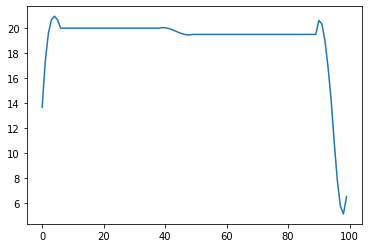

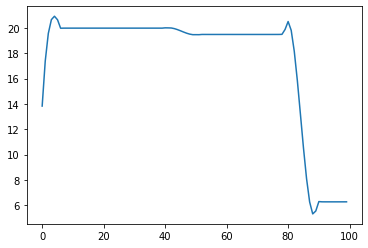

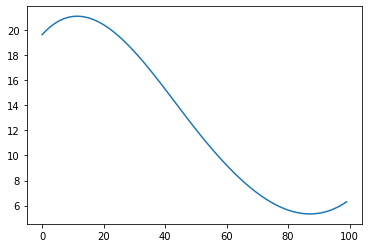

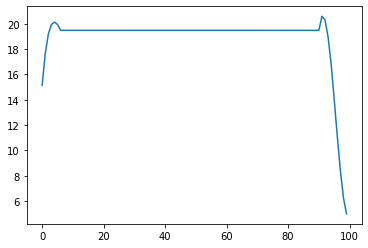

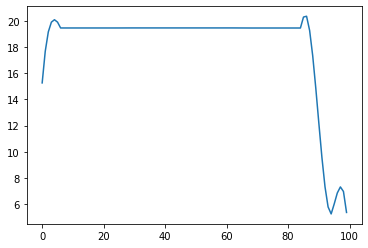

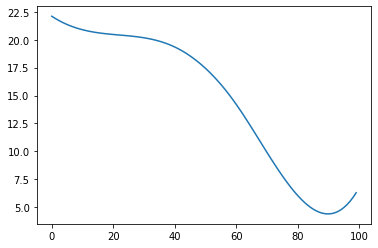

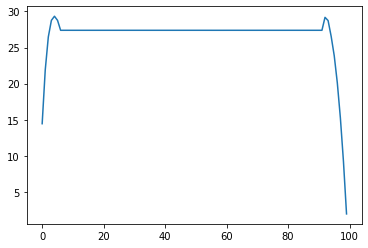

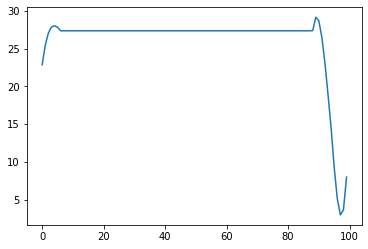

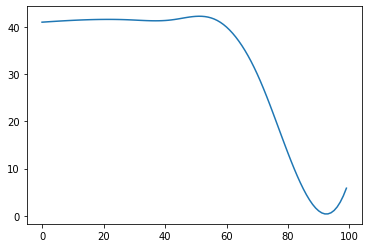

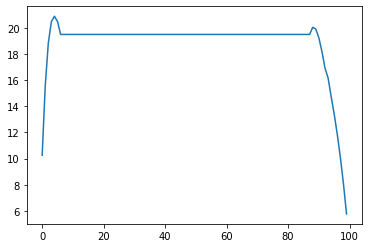

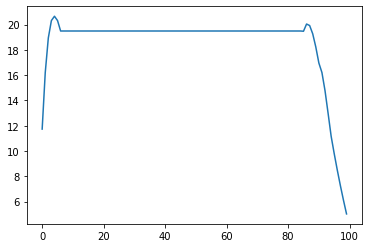

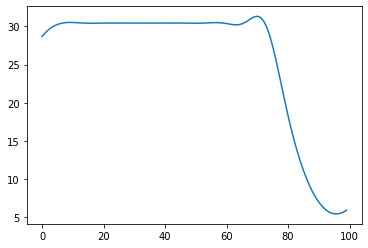

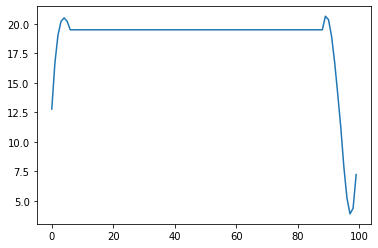

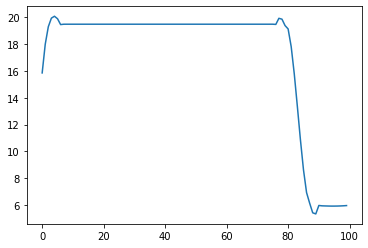

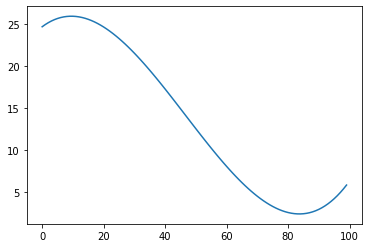

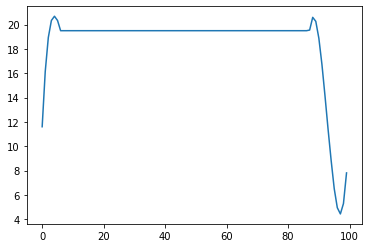

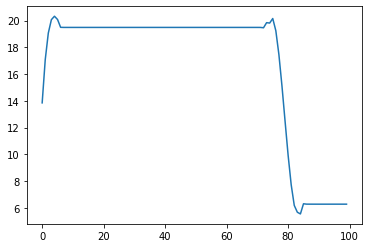

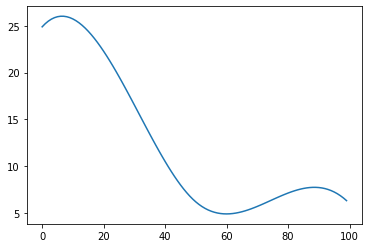

KeyboardInterrupt: 

In [221]:
#plot differents shapes
for y in all_shapes:
     
    plot(y)
    show()

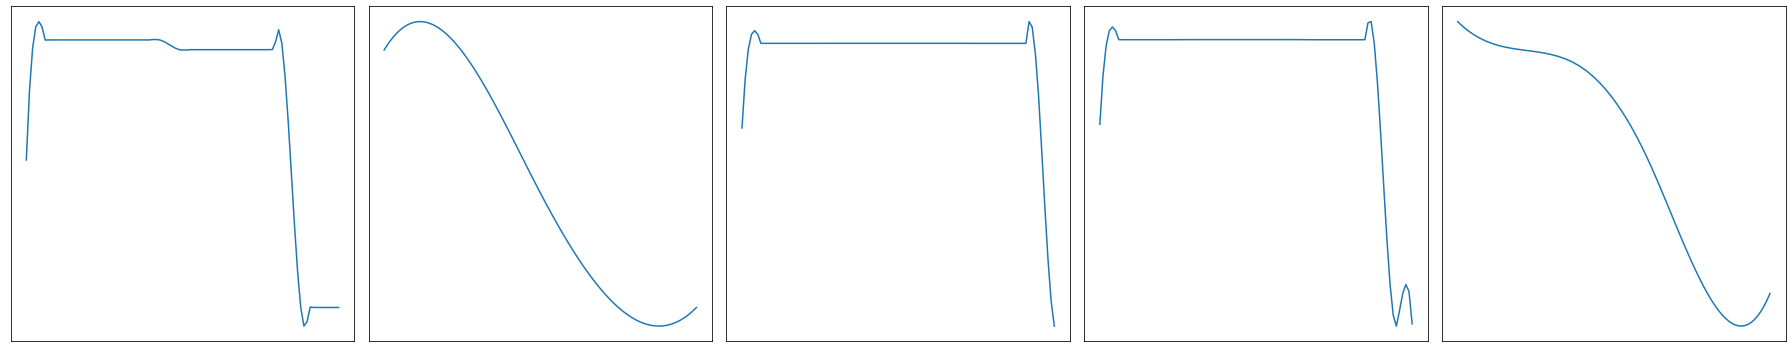

In [223]:
#plot differents shapes
#for y in all_shapes:
    
    
    
    
   # plot(y)
  #  show()

    
fig = plt.figure(figsize=(25, 5))
m = generated_images.shape[0]
sta=1
sto =6
for x in range (sta,sto):
    if x >= sta-1 : 
        ax = fig.add_subplot(1, 5, x-sta + 1)
        plt.plot(all_shapes[x])
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()
plt.show()

In [222]:
array_fingerprints = np.array(all_shapes)
print('shape', array_fingerprints.shape)


shape (348, 100)


## Generator

In [224]:
dim_in = 100

dense_dim = 200

out_dim = 50
#lr=1e-3 #decrease (train longer but prob don't skip lolcam iniam)
lr = 1e-4
opt = SGD(lr=lr)

#normalize or use linear (#use tan in middle)
#maybe use more layers
#increase layers



#PREMIER ESSAI - RAPPORT 
'''def get_generative(G_in, dense_dim=200, out_dim=50, lr=1e-3):
    x = Dense(dense_dim)(G_in)
    x = Activation('tanh')(x) 
    G_out = Dense(out_dim, activation='tanh')(x)
    G = Model(G_in, G_out)
    opt = SGD(lr=lr)
    G.compile(loss='binary_crossentropy', optimizer=opt)
    return G, G_out

G_in = Input(shape=[10])
G, G_out = get_generative(G_in)
G.summary()''' 

#DEUXIEME ESSAI 

#lr = 1e-3 to 1e-4

'''generator = Sequential()
generator.add(Dense(units = 200, input_shape=(dim_in,)))
generator.add(Activation('tanh'))
generator.add(Dropout(0.3)) #prevent over fitting and memorization

generator.add(Dense(units = 100))

generator.add(Dense(number_of_points, activation = "relu")) #re
generator.compile(loss=mse, optimizer=opt) #change loss (regression function instead)
generator.summary()'''


#TROISIEME ESSAI 


'''generator = Sequential()
generator.add(Dense(units = 400, input_shape=(dim_in,)))
generator.add(Activation('tanh'))
generator.add(Dropout(0.3)) #prevent over fitting and memorization

generator.add(Dense(units = 200))
generator.add(Dropout(0.3)) #prevent over fitting and memorization
generator.add(Dense(units = 100))

generator.add(Dense(number_of_points, activation = "relu")) #re
#generator.add(LeakyReLU(0.2))
#generator.compile(loss='binary_crossentropy', optimizer=opt) #change loss (regression function instead)
generator.compile(loss=mse, optimizer=opt) #change loss (regression function instead)
generator.summary()'''


#QUATRIEME ESSAI 


'''generator= Sequential()
generator.add(Dense(100,input_shape=(dim_in,)))
generator.add(LeakyReLU(0.2))

generator.add(Dense(200))
generator.add(LeakyReLU(0.2))

generator.add(Dense(400, activation = "tanh"))
generator.add(Dropout(0.3)) 

generator.add(Dense(200))
generator.add(LeakyReLU(0.2))
generator.add(Dense(number_of_points, activation = "relu")) #re

#generator.compile(optimizer=Adam(lr=0.002, beta_1=0.5),loss=mse)
generator.compile(loss=mse, optimizer=opt) #change loss (regression function instead)

generator.summary()'''


#CINQUIEME ESSAI 


'''generator = Sequential()
generator.add(Dense(256,input_shape=(dim_in,)))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(512))
#generator.add(Dense(512, activation = "tanh"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(1024))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(number_of_points, activation = "relu")) #re
generator.compile(loss=mse, optimizer=opt) #change loss (regression function instead)
generator.summary() '''       
  
#6 ESSAI 





'''generator = Sequential()
generator.add(Dense(256,input_shape=(dim_in,)))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
#generator.add(Dense(512))
generator.add(Dense(512, activation = "tanh"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Dropout(0.3)) 
generator.add(Dense(1024))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Dropout(0.3)) 
generator.add(Dense(number_of_points, activation = "relu")) #re
generator.compile(loss=mse, optimizer=opt) #change loss (regression function instead)
generator.summary()'''

#provide 3 differents kind of shapes

#7 ESSAI 

'''#trying new value of optimizer
lr = 1e-5
opt = SGD(lr=lr)


generator = Sequential()
generator.add(Dense(256,input_shape=(dim_in,)))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
#generator.add(Dense(512))
generator.add(Dense(512, activation = "tanh"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Dropout(0.3)) 
generator.add(Dense(1024))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Dropout(0.3)) 
generator.add(Dense(number_of_points, activation = "relu")) #re
generator.compile(loss=mse, optimizer=opt) #change loss (regression function instead)
generator.summary()'''


#8 ESSAI 

generator = Sequential()
generator.add(Dense(256,input_shape=(dim_in,)))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
#generator.add(Dense(512))
generator.add(Dense(512, activation = "tanh"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Dropout(0.3)) 
generator.add(Dense(1024))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Dropout(0.3)) 
generator.add(Dense(number_of_points, activation = "relu")) #re
generator.compile(optimizer=Adam(lr=0.002, beta_1=0.5),loss=mse)
generator.summary()


#using Adam instead of opt 
#back to normal training 
#shapes are better but convergence is less better


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 256)               1024      
_________________________________________________________________
dense_93 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_94 (Dense)             (None, 1024)            

## Discriminator

In [225]:
def get_discriminative(D_in, lr=1e-3, drate=.25, n_channels=50, conv_sz=5, leak=.2):
    x = Reshape((-1, 1))(D_in)
    x = Conv1D(n_channels, conv_sz, activation='relu')(x)
    x = Dropout(drate)(x)
    x = Flatten()(x)
    x = Dense(n_channels)(x)
    D_out = Dense(1, activation='sigmoid')(x)
    D = Model(D_in, D_out)
    dopt = Adam(lr=lr)
    D.compile(loss='binary_crossentropy', optimizer=dopt)
    return D, D_out

D_in = Input(shape=[number_of_points])
D, D_out = get_discriminative(D_in)
D.summary()
#arch seems fine #parameters?

Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 100)               0         
_________________________________________________________________
reshape_15 (Reshape)         (None, 100, 1)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 96, 50)            300       
_________________________________________________________________
dropout_38 (Dropout)         (None, 96, 50)            0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 4800)              0         
_________________________________________________________________
dense_96 (Dense)             (None, 50)                240050    
_________________________________________________________________
dense_97 (Dense)             (None, 1)                 51 

## GAN

In [226]:
'''def set_trainability(model, trainable=False):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable
        
def make_gan(GAN_in, G, D):
    set_trainability(D, False)
    x = G(GAN_in)
    GAN_out = D(x)
    GAN = Model(GAN_in, GAN_out)
    GAN.compile(loss='binary_crossentropy', optimizer=G.optimizer)
    return GAN, GAN_out

GAN_in = Input([10])
GAN, GAN_out = make_gan(GAN_in, G, D)
GAN.summary()'''


i1= Input((dim_in,))
l1= generator(i1)
o1= D(l1)
gan= Model(inputs=i1, output=o1)
gan.compile(Adam(1e-4), loss=binary_crossentropy)
gan.summary()

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 100)               0         
_________________________________________________________________
sequential_15 (Sequential)   (None, 100)               786276    
_________________________________________________________________
model_31 (Model)             (None, 1)                 240401    
Total params: 1,026,677
Trainable params: 1,026,165
Non-trainable params: 512
_________________________________________________________________


C:\Users\cossa\anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("mo...)`


## PreTrain Discriminator

In [218]:
batch_sample = len(array_fingerprints)
batch_size = 16  #16 or 32
batch_count=batch_sample//batch_size
print (batch_count)

21


In [ ]:
'''def getNoice(noise_dim = 10, batch_size = 9)
    XT = sample_data(n_samples=n_samples)
    XN_noise = np.random.uniform(0, 1, size=[n_samples, noise_dim])
def pretrain(G, D, noise_dim=10, n_samples=10000, batch_size=32):
    X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
    set_trainability(D, True)
    D.fit(X, y, epochs=1, batch_size=batch_size)

pretrain(G, D)'''

In [26]:
noise = np.random.uniform(0, 1, size=[batch_size, dim_in])
data_gen= generator.predict(noise)
print('data_gen_shape', data_gen.shape)


idx= np.random.randint(low=0,high=batch_sample,size=batch_size)
print('idx_shape',idx.shape)



data_real= array_fingerprints[idx] 
print('data_real.shape',data_real.shape)


xaux= np.concatenate( (data_gen,data_real) )
print('xaux.shape',xaux.shape)


yaux= np.zeros(2*batch_size) 
yaux[batch_size:]= 0.98 
print('yaux.shape',yaux.shape)
#print(yaux)
#print (xaux)
noise_gan= np.random.uniform(0, 1, size=[batch_size, dim_in])


print('noise_gan.shape',noise_gan.shape)
ygan= np.ones(batch_size)
print('ygan.shape',ygan.shape)




data_gen_shape (5, 100)
idx_shape (5,)
data_real.shape (5, 100)
xaux.shape (10, 100)
yaux.shape (10,)
noise_gan.shape (5, 100)
ygan.shape (5,)


In [227]:
iterable =10000
dloss_array = []
genloss_array = []
for i in range(iterable):
    for c in range(batch_count):
        
        noise = np.random.uniform(0, 1, size=[batch_size, dim_in])
        data_gen= generator.predict(noise)
        idx= np.random.randint(low=0,high=batch_sample,size=batch_size)
        data_real= array_fingerprints[idx]
    
        xaux= np.concatenate( (data_gen,data_real) )
        yaux= np.zeros(2*batch_size) 
        yaux[batch_size:]= 0.90
       
        D.trainable= True
        dloss= D.train_on_batch(xaux, yaux) 
        
        noise_gan= np.random.uniform(0, 1, size=[batch_size, dim_in])
        ygan= np.ones(batch_size)
        D.trainable= False #weight won't change (only update generator)
        gloss= gan.train_on_batch(noise_gan,ygan)
    
    # Print the results each 10 eps
    if i%100 == 0:
        print(f"epoch {i}")
        dloss_array.append(gloss)
        genloss_array.append(dloss)
        print(f"gloss: {gloss} dloss: {dloss}")

C:\Users\cossa\anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\cossa\anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch 0
gloss: 4.028132438659668 dloss: 3.7544384002685547
epoch 100
gloss: 2.768047571182251 dloss: 0.5854535102844238
epoch 200
gloss: 1.6715128421783447 dloss: 0.49065881967544556
epoch 300
gloss: 2.083435297012329 dloss: 0.49325111508369446
epoch 400
gloss: 1.8788390159606934 dloss: 0.48365920782089233
epoch 500
gloss: 1.102432131767273 dloss: 0.5485819578170776
epoch 600
gloss: 1.2876536846160889 dloss: 0.4905952513217926
epoch 700
gloss: 1.431469440460205 dloss: 0.5278403759002686
epoch 800
gloss: 1.5349757671356201 dloss: 0.4983488917350769
epoch 900
gloss: 1.0651142597198486 dloss: 0.5574710369110107
epoch 1000
gloss: 1.052351951599121 dloss: 0.579685389995575
epoch 1100
gloss: 1.2720434665679932 dloss: 0.5461221933364868
epoch 1200
gloss: 1.1362018585205078 dloss: 0.675723671913147
epoch 1300
gloss: 1.0912622213363647 dloss: 0.6149795055389404
epoch 1400
gloss: 1.2325713634490967 dloss: 0.6554433703422546
epoch 1500
gloss: 1.3009394407272339 dloss: 0.6070321798324585
epoch 160

[[29.521326  28.47699   29.803968  ... 11.226273  10.994906   6.5133495]
 [33.706978  31.486568  33.298306  ... 14.8873    13.403434   5.553138 ]
 [11.962498  11.508595  11.881893  ...  6.7276773  6.8800616  5.982792 ]
 ...
 [12.300469  12.203971  12.934181  ...  6.540298   6.767144   5.8021636]
 [20.281525  19.093254  20.170506  ...  8.257395   8.649053   6.511797 ]
 [25.103754  23.375477  24.197262  ...  9.9501505 10.180373   6.7416754]]


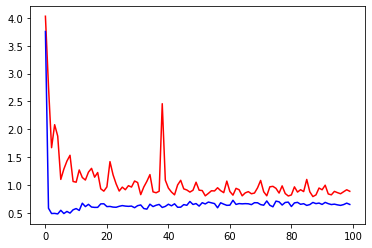

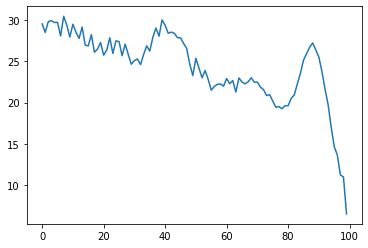

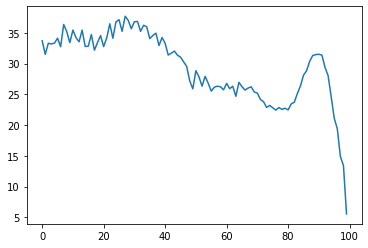

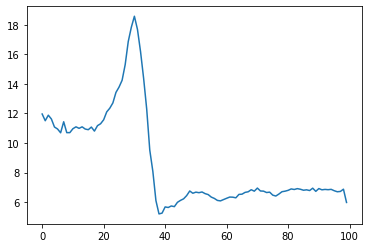

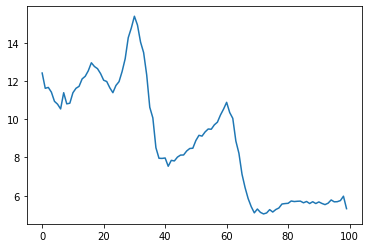

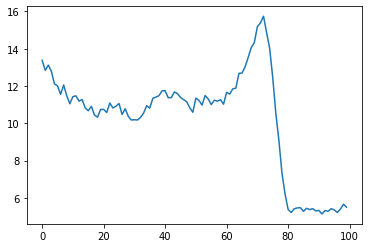

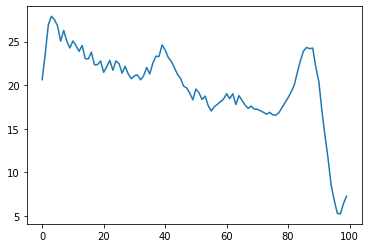

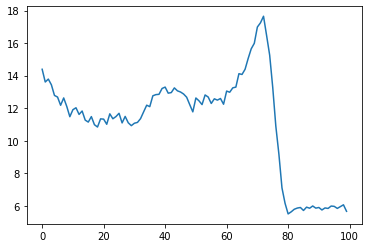

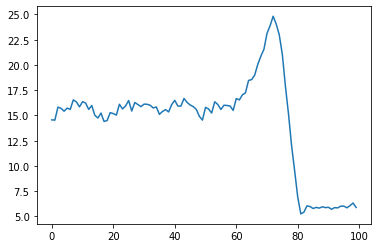

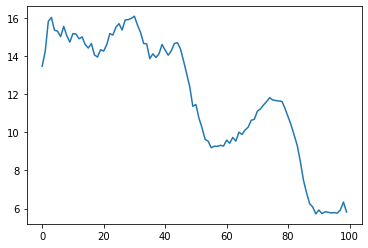

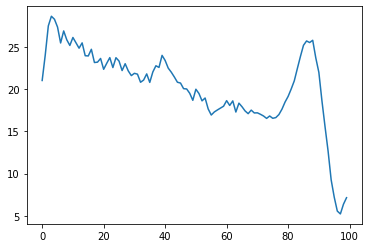

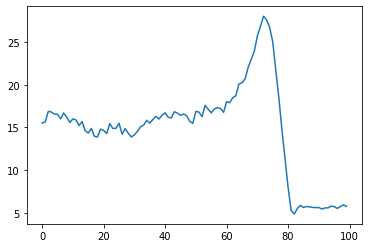

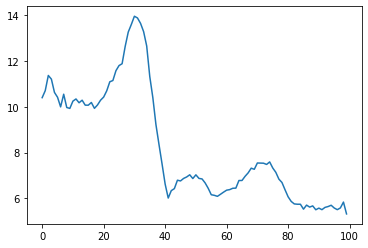

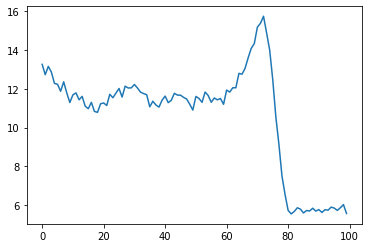

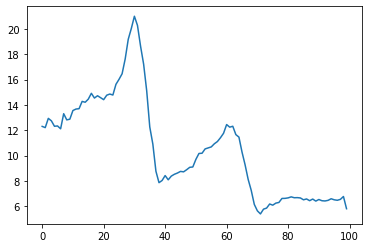

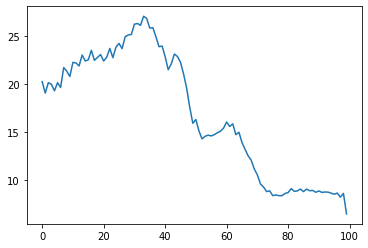

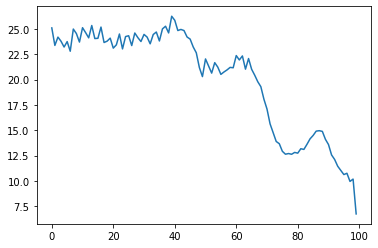

In [228]:
plt.figure()
plt.plot(dloss_array, 'r')
plt.plot(genloss_array, 'b')

#try the prediction 
noise = np.random.uniform(0, 1, size=[batch_size, dim_in])
generated_images= generator.predict(noise)
print (generated_images)
for x in range (generated_images.shape[0]):
    plt.figure()
    plt.plot(generated_images[x])
    #apply filters (smooth curve)
    
    
    
    
#plt.plot(generated_images[0], 'r') # plotting t, a separately 


[[13.340933  19.534815  21.041273  ...  4.052311   5.4415064  7.9340672]
 [15.801672  23.224606  25.177917  ...  2.335607   4.056367   7.488737 ]
 [13.569707  17.410786  20.097885  ...  7.974955   7.473432   5.9983306]
 ...
 [13.033286  15.01454   15.25315   ...  7.002246   7.116983   6.981932 ]
 [13.336986  16.697327  17.481388  ...  4.227982   5.557282   7.086489 ]
 [23.069126  26.204723  26.95768   ... 12.07009   10.086743   4.9848547]]


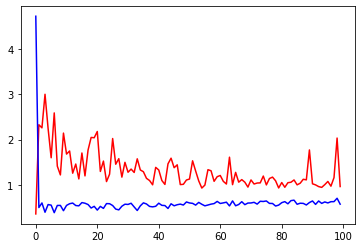

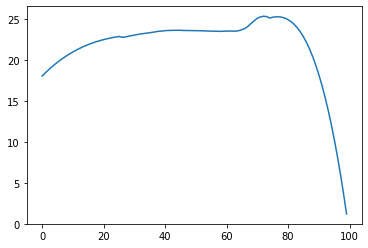

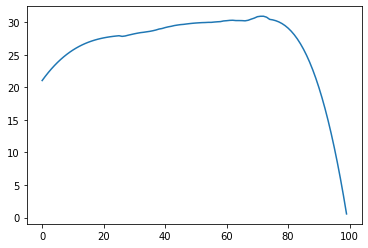

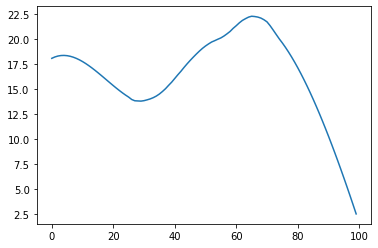

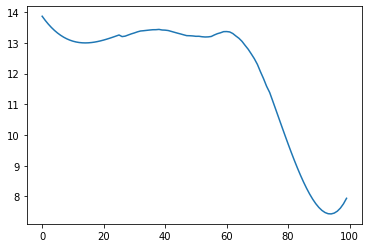

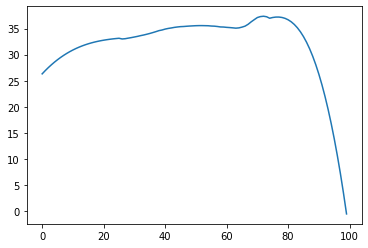

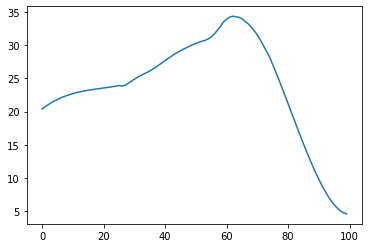

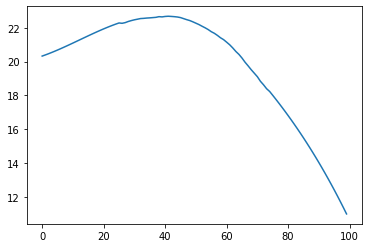

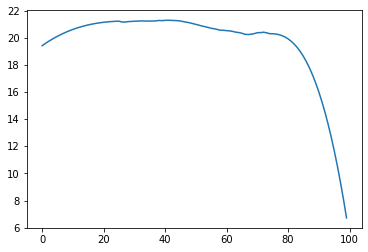

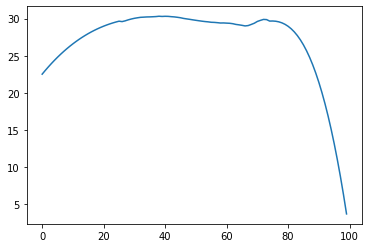

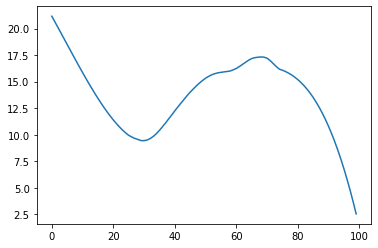

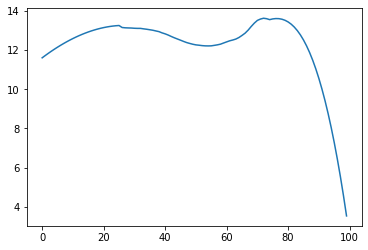

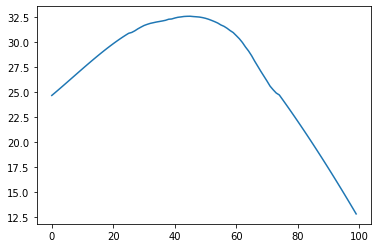

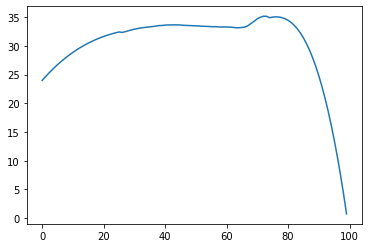

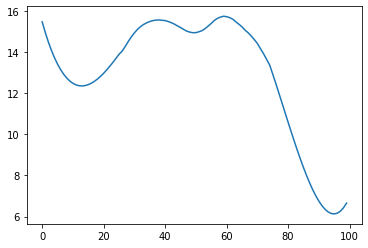

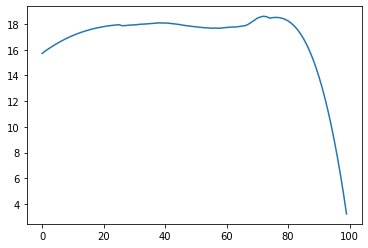

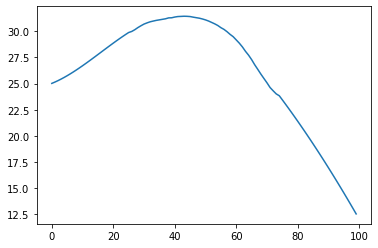

In [220]:
plt.figure()
plt.plot(dloss_array, 'r')
plt.plot(genloss_array, 'b')

from scipy.signal import savgol_filter

#try the prediction 
noise = np.random.uniform(0, 1, size=[batch_size, dim_in])
generated_images= generator.predict(noise)
print (generated_images)
for x in range (generated_images.shape[0]):
    
    
    yhat =1  # window size 51, polynomial order 3
    plt.figure()
    plt.plot(savgol_filter(generated_images[x], 51, 3))

    
    
#plt.plot(generated_images[0], 'r') # plotting t, a separately 


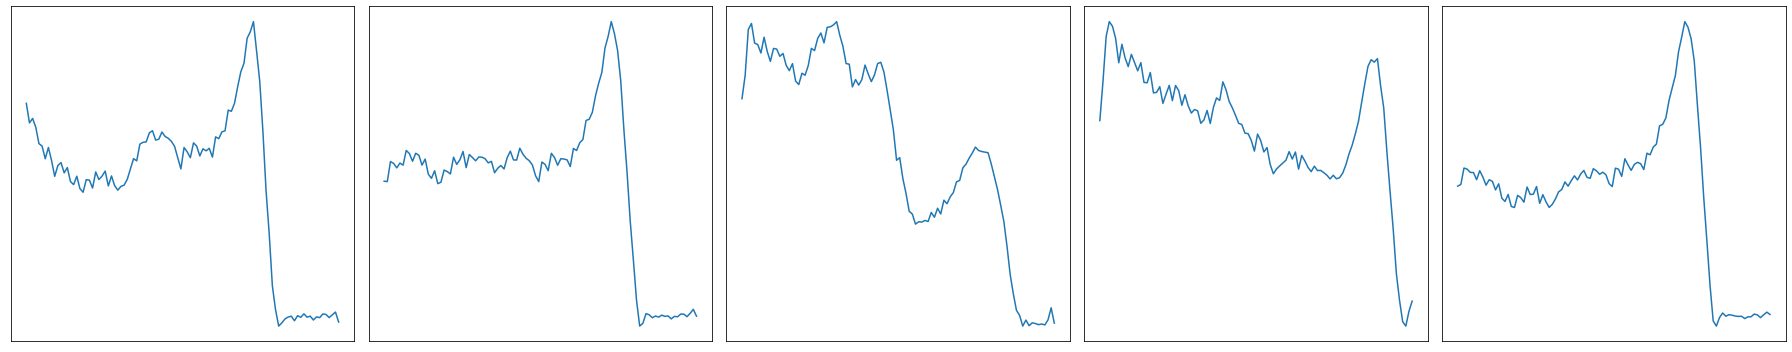

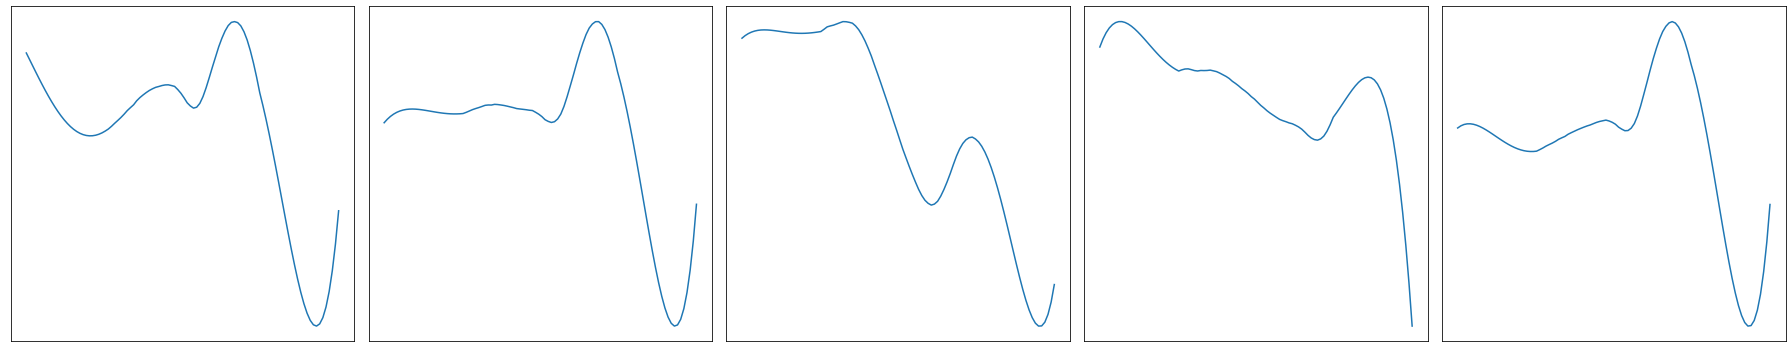

In [231]:
from scipy.signal import savgol_filter

fig = plt.figure(figsize=(25, 5))
m = generated_images.shape[0]
sta=6
sto =11
for x in range (sta,sto):
    if x >= sta-1 : 
        ax = fig.add_subplot(1, 5, x-sta + 1)
        plt.plot(generated_images[x])
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()
plt.show()

#https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way

fig = plt.figure(figsize=(25, 5))

for x in range (sta,sto):
    if x >= sta-1 : 
        ax = fig.add_subplot(1, 5, x-sta + 1)
        plt.plot(savgol_filter(generated_images[x], 51, 4))
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()
plt.show()   
